In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Breast/')]
groups = ['Histone', 'TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Breast/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/405 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("breast.bed", "r") as bed_file:

    for line in bed_file:

        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 5000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
win_in[:10]

[['chr1', 198047292, 198052292],
 ['chr1', 58062407, 58067407],
 ['chr1', 227010950, 227015950],
 ['chr1', 227010951, 227015951],
 ['chr1', 166590032, 166595032],
 ['chr1', 8255059, 8260059],
 ['chr1', 53343828, 53348828],
 ['chr1', 53343829, 53348829],
 ['chr1', 53343830, 53348830],
 ['chr1', 8255060, 8260060]]

In [7]:
win_out[:10]

[['chr1', 197947292, 197952292],
 ['chr1', 197897292, 197902292],
 ['chr1', 197872292, 197877292],
 ['chr1', 197897292, 197902292],
 ['chr1', 197947292, 197952292],
 ['chr1', 198047292, 198052292],
 ['chr1', 57962407, 57967407],
 ['chr1', 57912407, 57917407],
 ['chr1', 57887407, 57892407],
 ['chr1', 57912407, 57917407]]

In [8]:
print(len(win_in), len(win_out))

645495 3445703


In [30]:
sample_size = len(win_in) // 10
random_indices = np.random.choice(range(len(win_in)), size=sample_size, replace=False)
ints_in1 = np.array(win_in)[random_indices]
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(ints_in1), replace=False)]

In [14]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in), replace=False)]
#ints_out1 = np.array(win_out)


  0%|           | 4761/1936485 [00:59<5:08:06, 104.49it/s]

In [31]:
print(len(ints_in1), len(ints_out1))

64549 64549


In [32]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr1', '181528761', '181533761', '0'],
       ['chr5', '146323890', '146328890', '0'],
       ['chr12', '89728068', '89733068', '1'],
       ['chr20', '38154011', '38159011', '1'],
       ['chr17', '72406416', '72411416', '0'],
       ['chr19', '46009418', '46014418', '1'],
       ['chr2', '59489289', '59494289', '1'],
       ['chr1', '202270460', '202275460', '0'],
       ['chr8', '139919242', '139924242', '1'],
       ['chr8', '60272255', '60277255', '1']], dtype='<U21')

In [33]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row) 
        y.append(target)
    else:
        continue 

pbar.close()

100%|███████████████████████████████████████████████████████████████████████| 129098/129098 [19:57<00:00, 107.82it/s]


In [34]:
X = np.array(X)


scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [35]:
X = np.array(X)
X

array([[ 0.5177779 , -0.05644887, -0.02492802, ..., -0.08332188,
        -0.06078524, -0.02181331],
       [-0.11200365, -0.05644887, -0.02492802, ..., -0.08332188,
        -0.06078524, -0.02181331],
       [ 0.01208475, -0.05644887, -0.02492802, ..., -0.08332188,
        -0.06078524, -0.02181331],
       ...,
       [ 0.8251052 , -0.05644887, -0.02492802, ..., -0.08332188,
        -0.06078524, -0.02181331],
       [-0.33523506, -0.05644887, -0.02492802, ..., -0.08332188,
        -0.06078524, -0.02181331],
       [-0.33523506, -0.05644887, -0.02492802, ..., -0.08332188,
        -0.06078524, -0.02181331]], dtype=float32)

In [36]:
X.shape

(129098, 405)

In [37]:
y

tensor([0, 0, 1,  ..., 1, 0, 1])

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


Epoch 1/10
3228/3228 [==============================] - 65s 20ms/step - loss: 8.9275 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 2/10
3228/3228 [==============================] - 65s 20ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 3/10
3228/3228 [==============================] - 66s 20ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 4/10
3228/3228 [==============================] - 66s 20ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 5/10
3228/3228 [==============================] - 66s 20ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 6/10
3228/3228 [==============================] - 65s 20ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 7/10
3228/3228 [==============================] - 66s 20ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 -

In [ ]:
X

In [ ]:
y

In [ ]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [ ]:
X = X_copy
y = y_copy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1) 

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1 
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device) 

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_18197/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_18197/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6932, Train F1-score: 0.4934, Train ROC-AUC: 0.5003, Train PR-AUC: 0.5012, Test Loss: 0.6930, Test F1-score: 0.4979, Test ROC-AUC: 0.5099, Test PR-AUC: 0.5072
Epoch [2/20], Train Loss: 0.6929, Train F1-score: 0.5077, Train ROC-AUC: 0.5113, Train PR-AUC: 0.5110, Test Loss: 0.6928, Test F1-score: 0.4860, Test ROC-AUC: 0.5161, Test PR-AUC: 0.5120
Epoch [3/20], Train Loss: 0.6926, Train F1-score: 0.5102, Train ROC-AUC: 0.5163, Train PR-AUC: 0.5165, Test Loss: 0.6929, Test F1-score: 0.4679, Test ROC-AUC: 0.5126, Test PR-AUC: 0.5111
Epoch [4/20], Train Loss: 0.6922, Train F1-score: 0.5123, Train ROC-AUC: 0.5208, Train PR-AUC: 0.5204, Test Loss: 0.6930, Test F1-score: 0.5050, Test ROC-AUC: 0.5124, Test PR-AUC: 0.5097
Epoch [5/20], Train Loss: 0.6920, Train F1-score: 0.5124, Train ROC-AUC: 0.5206, Train PR-AUC: 0.5214, Test Loss: 0.6929, Test F1-score: 0.5072, Test ROC-AUC: 0.5128, Test PR-AUC: 0.5109
Epoch [6/20], Train Loss: 0.6916, Train F1-score: 0.5136, Train R

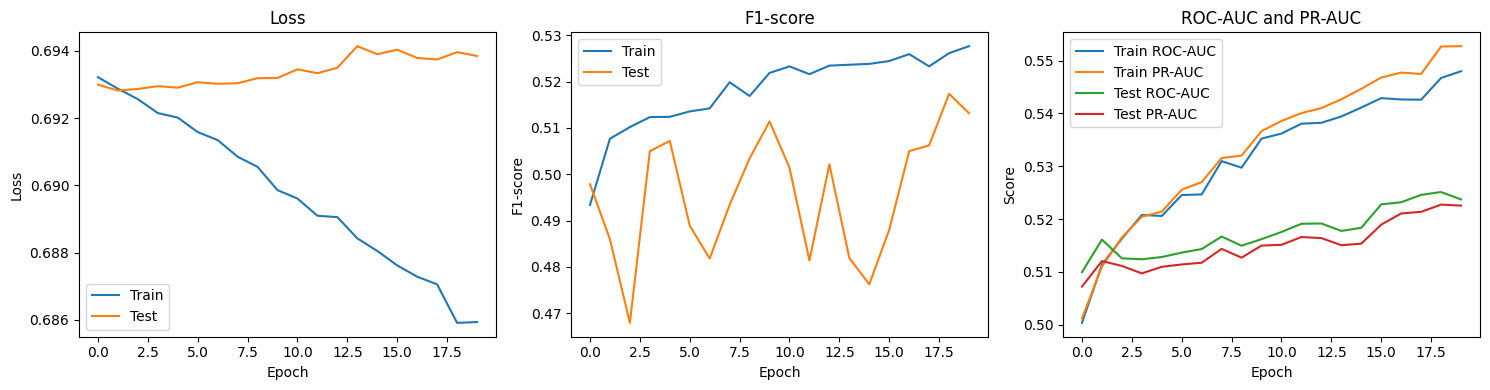

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature Histone_H3K27me3 importance: 0.0034469403563128775
Feature TFs_GRHL2 importance: 0.002439969016266419
Feature TFs_SMARCA4 importance: 0.0022463206816421
Feature Histone_H3K79me2 importance: 0.002207591014717236
Feature TFs_CHD8 importance: 0.0021301316808675086
Feature TFs_Epitope tags importance: 0.002052672347017781
Feature TFs_TRIM25 importance: 0.002013942680092917
Feature Histone_H3K4ox importance: 0.0018202943454685983
Feature TFs_BRD9 importance: 0.0017041053446940069
Feature TFs_SFPQ importance: 0.0017041053446940069
Feature Histone_H4K8ac importance: 0.0016266460108442793
Feature Histone_H3K4me1 importance: 0.0015879163439194155
Feature TFs_FOSL1 importance: 0.0015879163439194155
Feature TFs_5-mC importance: 0.0015491866769945517
Feature TFs_KDM4A importance: 0.0015491866769945517
Feature TFs_DNMT3A importance: 0.0013942680092950965
Feature TFs_FOXM1 importance: 0.0013942680092950965
Feature TFs_JUN importance: 0.0013555383423702327
Feature TFs_ZBTB33 importance: 0.001

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out



input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_18197/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_18197/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6942, Train F1-score: 0.4974, Train ROC-AUC: 0.5306, Train PR-AUC: 0.6414, Test Loss: 0.6930, Test F1-score: 0.5056, Test ROC-AUC: 0.5075, Test PR-AUC: 0.5067
Epoch [2/20], Train Loss: 0.6937, Train F1-score: 0.4854, Train ROC-AUC: 0.3333, Train PR-AUC: 0.2697, Test Loss: 0.6933, Test F1-score: 0.4973, Test ROC-AUC: 0.5135, Test PR-AUC: 0.5114
Epoch [3/20], Train Loss: 0.6932, Train F1-score: 0.2256, Train ROC-AUC: 0.2292, Train PR-AUC: 0.4128, Test Loss: 0.6936, Test F1-score: 0.4136, Test ROC-AUC: 0.5108, Test PR-AUC: 0.5078
Epoch [4/20], Train Loss: 0.6928, Train F1-score: 0.8398, Train ROC-AUC: 0.7250, Train PR-AUC: 0.6883, Test Loss: 0.6930, Test F1-score: 0.4508, Test ROC-AUC: 0.5120, Test PR-AUC: 0.5104
Epoch [5/20], Train Loss: 0.6923, Train F1-score: 0.4759, Train ROC-AUC: 0.5714, Train PR-AUC: 0.5053, Test Loss: 0.6930, Test F1-score: 0.5063, Test ROC-AUC: 0.5204, Test PR-AUC: 0.5174
Epoch [6/20], Train Loss: 0.6919, Train F1-score: 0.3468, Train R

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_18197/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_18197/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6930, Train F1-score: 0.4901, Train ROC-AUC: 0.5083, Train PR-AUC: 0.5080, Test Loss: 0.6928, Test F1-score: 0.4569, Test ROC-AUC: 0.5182, Test PR-AUC: 0.5159
Epoch [2/20], Train Loss: 0.6914, Train F1-score: 0.5156, Train ROC-AUC: 0.5261, Train PR-AUC: 0.5280, Test Loss: 0.6938, Test F1-score: 0.4876, Test ROC-AUC: 0.5170, Test PR-AUC: 0.5145
Epoch [3/20], Train Loss: 0.6862, Train F1-score: 0.5292, Train ROC-AUC: 0.5498, Train PR-AUC: 0.5547, Test Loss: 0.6938, Test F1-score: 0.5137, Test ROC-AUC: 0.5238, Test PR-AUC: 0.5223
Epoch [4/20], Train Loss: 0.6779, Train F1-score: 0.5451, Train ROC-AUC: 0.5775, Train PR-AUC: 0.5834, Test Loss: 0.6961, Test F1-score: 0.5078, Test ROC-AUC: 0.5305, Test PR-AUC: 0.5279
Epoch [5/20], Train Loss: 0.6689, Train F1-score: 0.5610, Train ROC-AUC: 0.6029, Train PR-AUC: 0.6107, Test Loss: 0.6971, Test F1-score: 0.4851, Test ROC-AUC: 0.5373, Test PR-AUC: 0.5336
Epoch [6/20], Train Loss: 0.6606, Train F1-score: 0.5693, Train R

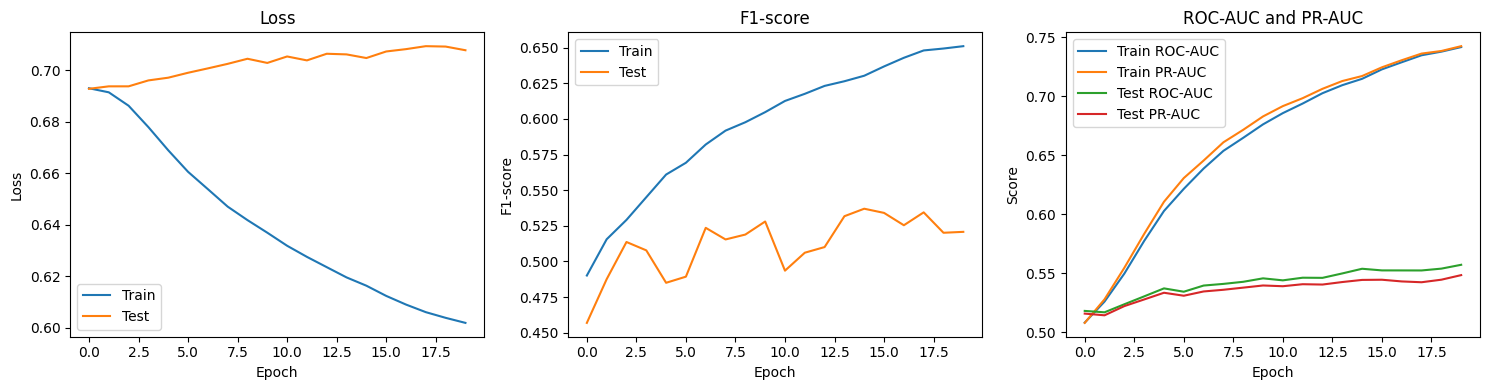

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_18197/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_18197/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6935, Train F1-score: 0.5028, Train ROC-AUC: 0.5032, Train PR-AUC: 0.5027, Test Loss: 0.6930, Test F1-score: 0.4589, Test ROC-AUC: 0.5134, Test PR-AUC: 0.5136
Epoch [2/30], Train Loss: 0.6927, Train F1-score: 0.5089, Train ROC-AUC: 0.5146, Train PR-AUC: 0.5166, Test Loss: 0.6932, Test F1-score: 0.4263, Test ROC-AUC: 0.5166, Test PR-AUC: 0.5122
Epoch [3/30], Train Loss: 0.6915, Train F1-score: 0.5185, Train ROC-AUC: 0.5279, Train PR-AUC: 0.5288, Test Loss: 0.6931, Test F1-score: 0.4432, Test ROC-AUC: 0.5158, Test PR-AUC: 0.5135
Epoch [4/30], Train Loss: 0.6895, Train F1-score: 0.5224, Train ROC-AUC: 0.5365, Train PR-AUC: 0.5389, Test Loss: 0.6934, Test F1-score: 0.4584, Test ROC-AUC: 0.5183, Test PR-AUC: 0.5167
Epoch [5/30], Train Loss: 0.6867, Train F1-score: 0.5267, Train ROC-AUC: 0.5465, Train PR-AUC: 0.5518, Test Loss: 0.6941, Test F1-score: 0.4648, Test ROC-AUC: 0.5200, Test PR-AUC: 0.5186
Epoch [6/30], Train Loss: 0.6840, Train F1-score: 0.5313, Train R

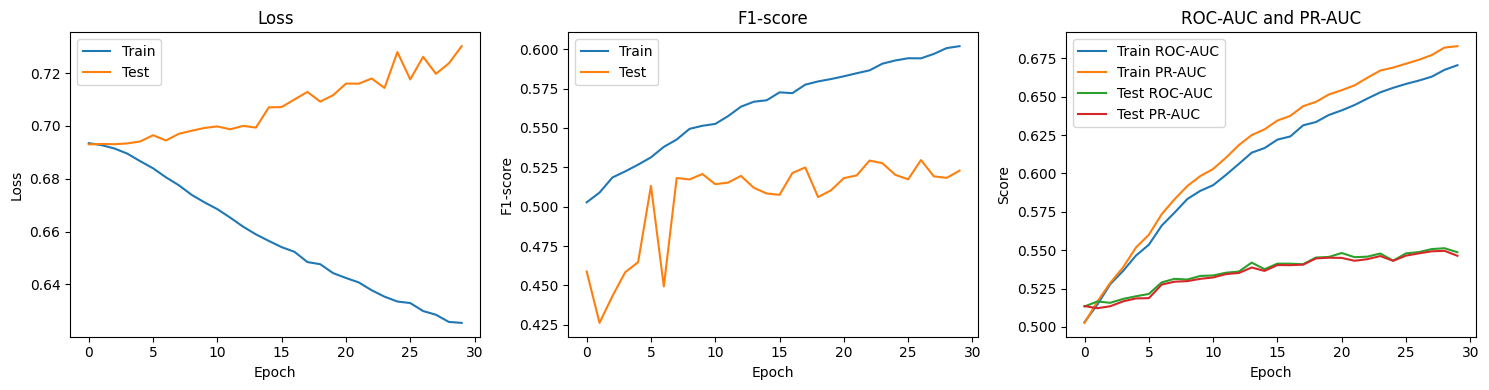

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_18197/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_18197/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:35<00:00, 67.84it/s]


Epoch [1/20], Train Loss: 0.6938, Train F1-score: 0.4986, Train ROC-AUC: 0.5004, Train PR-AUC: 0.5021, Test Loss: 0.6935, Test F1-score: 0.3710, Test ROC-AUC: 0.5066, Test PR-AUC: 0.5061


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:33<00:00, 68.71it/s]


Epoch [2/20], Train Loss: 0.6933, Train F1-score: 0.5035, Train ROC-AUC: 0.5065, Train PR-AUC: 0.5085, Test Loss: 0.6929, Test F1-score: 0.4474, Test ROC-AUC: 0.5076, Test PR-AUC: 0.5065


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.60it/s]


Epoch [3/20], Train Loss: 0.6923, Train F1-score: 0.5061, Train ROC-AUC: 0.5138, Train PR-AUC: 0.5183, Test Loss: 0.6928, Test F1-score: 0.4552, Test ROC-AUC: 0.5095, Test PR-AUC: 0.5098


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:33<00:00, 68.69it/s]


Epoch [4/20], Train Loss: 0.6907, Train F1-score: 0.5116, Train ROC-AUC: 0.5241, Train PR-AUC: 0.5306, Test Loss: 0.6931, Test F1-score: 0.4548, Test ROC-AUC: 0.5136, Test PR-AUC: 0.5135


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.55it/s]


Epoch [5/20], Train Loss: 0.6879, Train F1-score: 0.5160, Train ROC-AUC: 0.5320, Train PR-AUC: 0.5408, Test Loss: 0.6951, Test F1-score: 0.4268, Test ROC-AUC: 0.5139, Test PR-AUC: 0.5148


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.61it/s]


Epoch [6/20], Train Loss: 0.6856, Train F1-score: 0.5228, Train ROC-AUC: 0.5415, Train PR-AUC: 0.5515, Test Loss: 0.6968, Test F1-score: 0.4297, Test ROC-AUC: 0.5142, Test PR-AUC: 0.5145


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.65it/s]


Epoch [7/20], Train Loss: 0.6822, Train F1-score: 0.5250, Train ROC-AUC: 0.5483, Train PR-AUC: 0.5607, Test Loss: 0.6958, Test F1-score: 0.4212, Test ROC-AUC: 0.5156, Test PR-AUC: 0.5172


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.54it/s]


Epoch [8/20], Train Loss: 0.6788, Train F1-score: 0.5304, Train ROC-AUC: 0.5593, Train PR-AUC: 0.5727, Test Loss: 0.6981, Test F1-score: 0.4451, Test ROC-AUC: 0.5196, Test PR-AUC: 0.5212


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.49it/s]


Epoch [9/20], Train Loss: 0.6751, Train F1-score: 0.5369, Train ROC-AUC: 0.5675, Train PR-AUC: 0.5816, Test Loss: 0.6999, Test F1-score: 0.4365, Test ROC-AUC: 0.5191, Test PR-AUC: 0.5224


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.53it/s]


Epoch [10/20], Train Loss: 0.6722, Train F1-score: 0.5360, Train ROC-AUC: 0.5715, Train PR-AUC: 0.5871, Test Loss: 0.7086, Test F1-score: 0.4485, Test ROC-AUC: 0.5259, Test PR-AUC: 0.5266


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.47it/s]


Epoch [11/20], Train Loss: 0.6681, Train F1-score: 0.5453, Train ROC-AUC: 0.5823, Train PR-AUC: 0.5976, Test Loss: 0.7068, Test F1-score: 0.4520, Test ROC-AUC: 0.5261, Test PR-AUC: 0.5264


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.13it/s]


Epoch [12/20], Train Loss: 0.6638, Train F1-score: 0.5471, Train ROC-AUC: 0.5894, Train PR-AUC: 0.6069, Test Loss: 0.7122, Test F1-score: 0.4261, Test ROC-AUC: 0.5311, Test PR-AUC: 0.5312


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.34it/s]


Epoch [13/20], Train Loss: 0.6618, Train F1-score: 0.5483, Train ROC-AUC: 0.5934, Train PR-AUC: 0.6104, Test Loss: 0.7092, Test F1-score: 0.4396, Test ROC-AUC: 0.5266, Test PR-AUC: 0.5276


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.52it/s]


Epoch [14/20], Train Loss: 0.6580, Train F1-score: 0.5497, Train ROC-AUC: 0.5981, Train PR-AUC: 0.6176, Test Loss: 0.7061, Test F1-score: 0.4496, Test ROC-AUC: 0.5276, Test PR-AUC: 0.5289


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.17it/s]


Epoch [15/20], Train Loss: 0.6560, Train F1-score: 0.5563, Train ROC-AUC: 0.6037, Train PR-AUC: 0.6215, Test Loss: 0.7120, Test F1-score: 0.4488, Test ROC-AUC: 0.5313, Test PR-AUC: 0.5308


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.20it/s]


Epoch [16/20], Train Loss: 0.6520, Train F1-score: 0.5614, Train ROC-AUC: 0.6119, Train PR-AUC: 0.6299, Test Loss: 0.7221, Test F1-score: 0.4496, Test ROC-AUC: 0.5353, Test PR-AUC: 0.5354


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.31it/s]


Epoch [17/20], Train Loss: 0.6492, Train F1-score: 0.5580, Train ROC-AUC: 0.6146, Train PR-AUC: 0.6343, Test Loss: 0.7148, Test F1-score: 0.4702, Test ROC-AUC: 0.5278, Test PR-AUC: 0.5317


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.14it/s]


Epoch [18/20], Train Loss: 0.6463, Train F1-score: 0.5633, Train ROC-AUC: 0.6193, Train PR-AUC: 0.6393, Test Loss: 0.7182, Test F1-score: 0.4599, Test ROC-AUC: 0.5361, Test PR-AUC: 0.5353


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:34<00:00, 68.33it/s]


Epoch [19/20], Train Loss: 0.6440, Train F1-score: 0.5684, Train ROC-AUC: 0.6235, Train PR-AUC: 0.6427, Test Loss: 0.7298, Test F1-score: 0.4846, Test ROC-AUC: 0.5355, Test PR-AUC: 0.5367


100%|████████████████████████████████████████████████████████████████████████████| 6455/6455 [01:35<00:00, 67.90it/s]


Epoch [20/20], Train Loss: 0.6409, Train F1-score: 0.5716, Train ROC-AUC: 0.6301, Train PR-AUC: 0.6489, Test Loss: 0.7277, Test F1-score: 0.4902, Test ROC-AUC: 0.5378, Test PR-AUC: 0.5384


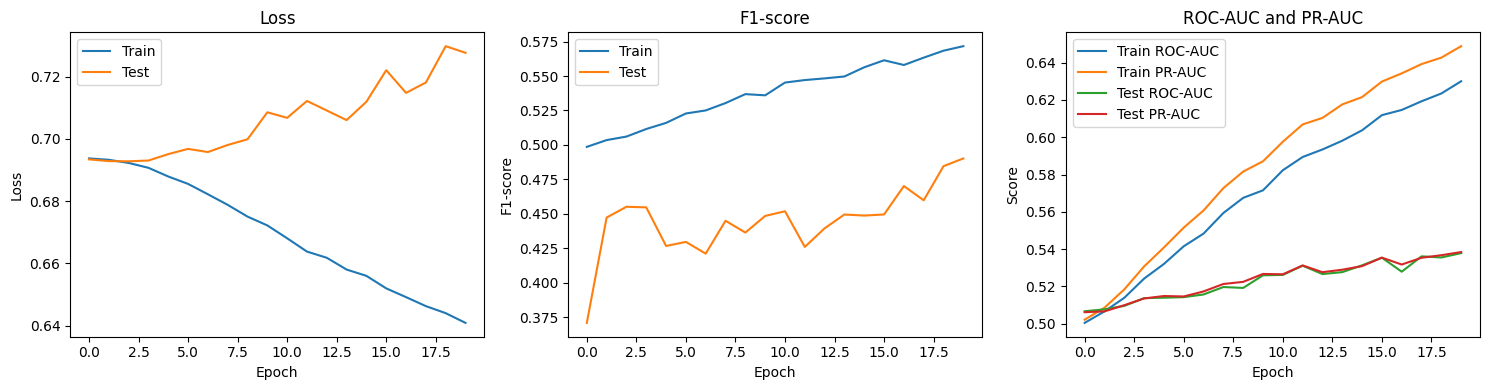

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)


epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.7007, Train F1-score: 0.4518, Train ROC-AUC: 0.5027, Train PR-AUC: 0.5038, Test Loss: 0.7099, Test F1-score: 0.4488, Test ROC-AUC: 0.4991, Test PR-AUC: 0.4982
Epoch [2/50], Train Loss: 0.7070, Train F1-score: 0.4724, Train ROC-AUC: 0.5035, Train PR-AUC: 0.5051, Test Loss: 0.6991, Test F1-score: 0.4740, Test ROC-AUC: 0.5018, Test PR-AUC: 0.5001
Epoch [3/50], Train Loss: 0.6974, Train F1-score: 0.4758, Train ROC-AUC: 0.5070, Train PR-AUC: 0.5081, Test Loss: 0.6975, Test F1-score: 0.4758, Test ROC-AUC: 0.5056, Test PR-AUC: 0.5029
Epoch [4/50], Train Loss: 0.6975, Train F1-score: 0.4702, Train ROC-AUC: 0.5074, Train PR-AUC: 0.5087, Test Loss: 0.6990, Test F1-score: 0.4698, Test ROC-AUC: 0.5086, Test PR-AUC: 0.5048
Epoch [5/50], Train Loss: 0.6993, Train F1-score: 0.4744, Train ROC-AUC: 0.5091, Train PR-AUC: 0.5105, Test Loss: 0.6969, Test F1-score: 0.4735, Test ROC-AUC: 0.5086, Test PR-AUC: 0.5049
Epoch [6/50], Train Loss: 0.6963, Train F1-score: 0.4920, Train R

Epoch [45/50], Train Loss: 0.6848, Train F1-score: 0.5330, Train ROC-AUC: 0.5398, Train PR-AUC: 0.5437, Test Loss: 0.6940, Test F1-score: 0.5072, Test ROC-AUC: 0.5123, Test PR-AUC: 0.5094
Epoch [46/50], Train Loss: 0.6846, Train F1-score: 0.5372, Train ROC-AUC: 0.5399, Train PR-AUC: 0.5440, Test Loss: 0.6940, Test F1-score: 0.5103, Test ROC-AUC: 0.5120, Test PR-AUC: 0.5093
Epoch [47/50], Train Loss: 0.6843, Train F1-score: 0.5363, Train ROC-AUC: 0.5399, Train PR-AUC: 0.5441, Test Loss: 0.6942, Test F1-score: 0.5107, Test ROC-AUC: 0.5119, Test PR-AUC: 0.5092
Epoch [48/50], Train Loss: 0.6841, Train F1-score: 0.5347, Train ROC-AUC: 0.5402, Train PR-AUC: 0.5445, Test Loss: 0.6943, Test F1-score: 0.5072, Test ROC-AUC: 0.5119, Test PR-AUC: 0.5091
Epoch [49/50], Train Loss: 0.6839, Train F1-score: 0.5359, Train ROC-AUC: 0.5410, Train PR-AUC: 0.5454, Test Loss: 0.6943, Test F1-score: 0.5087, Test ROC-AUC: 0.5120, Test PR-AUC: 0.5092
Epoch [50/50], Train Loss: 0.6837, Train F1-score: 0.5396, T

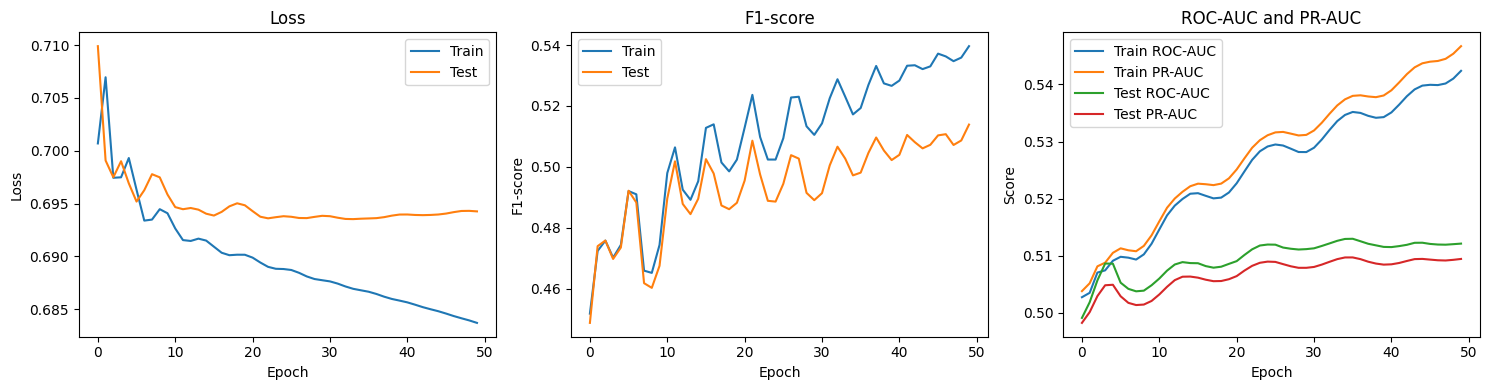

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [54]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [55]:
df_x

,Histone_H3K36me3,Histone_H4K20me3,Histone_H2A,Histone_H3K36me2,Histone_H3K4ac,Histone_H4K20me1,Histone_H3K23ac,Histone_H3K4ox,Histone_H3K27ac,Histone_H2A.X,...,TFs_ZNF444,TFs_ZNF507,TFs_ZNF512B,TFs_ZNF516,TFs_ZNF574,TFs_ZNF579,TFs_ZNF592,TFs_ZNF687,TFs_ZNF711,TFs_ZNF8
0,0.517778,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,-0.409269,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
1,-0.112004,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,0.299108,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
2,0.012085,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,1.396129,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
3,-0.335235,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,1.619063,0.323846,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
4,-0.335235,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,3.010398,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129093,-0.335235,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,-0.294630,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
129094,0.085724,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,0.192113,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
129095,0.825105,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,-0.201931,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813
129096,-0.335235,-0.056449,-0.024928,-0.037175,-0.156412,-0.041012,-0.129592,-0.184991,3.194839,-0.018902,...,-0.091581,-0.034078,-0.040126,-0.012233,-0.040551,-0.07725,-0.042806,-0.083322,-0.060785,-0.021813


In [56]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [57]:
df_y

,target
0,0
1,0
2,1
3,1
4,0
...,...
129093,0
129094,0
129095,1
129096,0


In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_18197/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.0213094281407054
Histone_H4K20me3: 0.000841867682744553
Histone_H2A: 3.863403253572469e-05
Histone_H3K36me2: 0.00013037421019176186
Histone_H3K4ac: 0.0009159680361491414
Histone_H4K20me1: 0.0002199088236669031
Histone_H3K23ac: 0.0006677518816921187
Histone_H3K4ox: 0.009625096227304392
Histone_H3K27ac: 0.049306724519744514
Histone_H2A.X: 5.7955770177132754e-06
Histone_H3K9me3: 0.030092881283619078
Histone_H3K9me2: 0.0028336321679035435
Histone_H2A.Z: 0.00450625797251672
Histone_H1.X: 5.229177728655543e-07
Histone_H3K18ac: 0.00042634293251884574
Histone_H3: 0.002049730372016863
Histone_H1.4S187ph: 2.4541700529228004e-05
Histone_H2BK120ub1: 0.0013669607718902305
Histone_H3T45ph: 1.9650752830662105e-05
Histone_H3K79me2: 0.007262531498013475
Histone_H4K8ac: 0.003739388672623528
Histone_H4K12ac: 0.009006907298032723
Histone_H3K9K14ac: 0.001379354691278983
Histone_H2Bub: 0.00036272752951248434
Histone_H2A.XS139ph: 0.0014793666194532205
Histone_H4ac: 5.527478490409318e-07
H

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_18197/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.5873
ROC-AUC: 0.6055
PR-AUC: 0.6978


              feature  importance
32   Histone_H3K27me3    0.050234
8     Histone_H3K27ac    0.048366
37    Histone_H3K4me1    0.036385
152         TFs_FOXA1    0.035077
299          TFs_SFPQ    0.029506
..                ...         ...
53          TFs_5-hmC    0.000000
218         TFs_MEPCE    0.000000
90          TFs_CASP3    0.000000
286         TFs_RDme1    0.000000
147        TFs_FBXO44    0.000000

[405 rows x 2 columns]


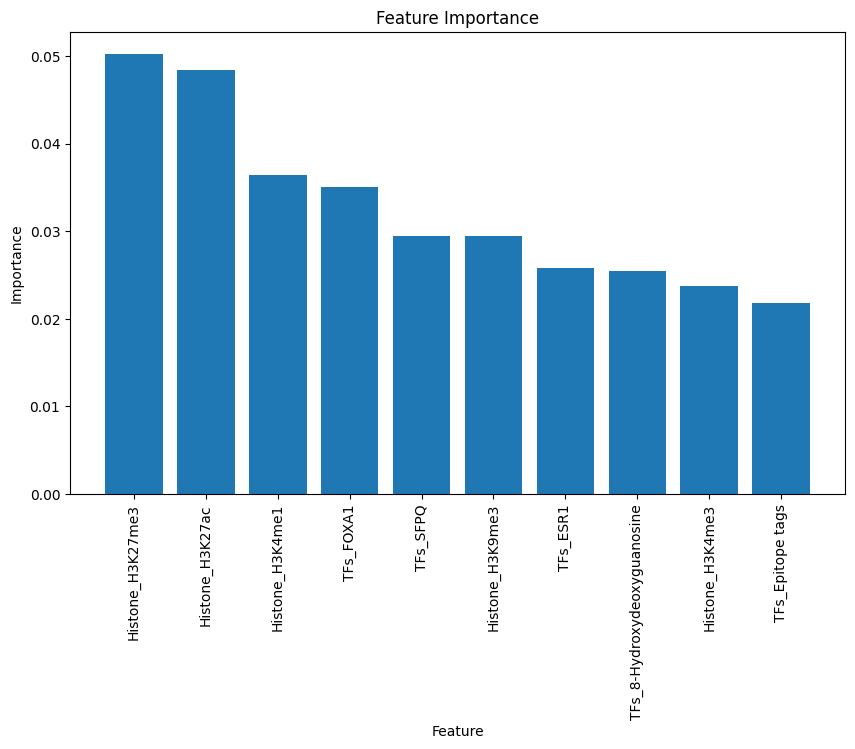

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [61]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6930785	total: 74.8ms	remaining: 1m 14s
1:	learn: 0.6929982	total: 98.3ms	remaining: 49.1s
2:	learn: 0.6928925	total: 124ms	remaining: 41.3s
3:	learn: 0.6928035	total: 149ms	remaining: 37.1s
4:	learn: 0.6927113	total: 175ms	remaining: 34.8s
5:	learn: 0.6926001	total: 201ms	remaining: 33.4s
6:	learn: 0.6924778	total: 228ms	remaining: 32.4s
7:	learn: 0.6923843	total: 253ms	remaining: 31.3s
8:	learn: 0.6923162	total: 276ms	remaining: 30.3s
9:	learn: 0.6922290	total: 301ms	remaining: 29.8s
10:	learn: 0.6921501	total: 327ms	remaining: 29.4s
11:	learn: 0.6920917	total: 350ms	remaining: 28.8s
12:	learn: 0.6920038	total: 377ms	remaining: 28.6s
13:	learn: 0.6919304	total: 400ms	remaining: 28.2s
14:	learn: 0.6918624	total: 426ms	remaining: 28s
15:	learn: 0.6917616	total: 453ms	remaining: 27.9s
16:	learn: 0.6916997	total: 479ms	remaining: 27.7s
17:	learn: 0.6915822	total: 506ms	remaining: 27.6s
18:	learn: 0.6914599	total: 533ms	remaining: 27.5s
19:	learn: 0.6913729	total: 558ms	remain

161:	learn: 0.6807468	total: 4.28s	remaining: 22.1s
162:	learn: 0.6806668	total: 4.3s	remaining: 22.1s
163:	learn: 0.6805274	total: 4.33s	remaining: 22.1s
164:	learn: 0.6804438	total: 4.35s	remaining: 22s
165:	learn: 0.6803135	total: 4.38s	remaining: 22s
166:	learn: 0.6802080	total: 4.41s	remaining: 22s
167:	learn: 0.6800831	total: 4.44s	remaining: 22s
168:	learn: 0.6799905	total: 4.46s	remaining: 22s
169:	learn: 0.6798734	total: 4.49s	remaining: 21.9s
170:	learn: 0.6797666	total: 4.52s	remaining: 21.9s
171:	learn: 0.6796376	total: 4.55s	remaining: 21.9s
172:	learn: 0.6795372	total: 4.58s	remaining: 21.9s
173:	learn: 0.6794568	total: 4.6s	remaining: 21.9s
174:	learn: 0.6793795	total: 4.63s	remaining: 21.8s
175:	learn: 0.6792807	total: 4.66s	remaining: 21.8s
176:	learn: 0.6792115	total: 4.68s	remaining: 21.8s
177:	learn: 0.6791316	total: 4.71s	remaining: 21.7s
178:	learn: 0.6790305	total: 4.74s	remaining: 21.7s
179:	learn: 0.6789424	total: 4.76s	remaining: 21.7s
180:	learn: 0.6788722	to

321:	learn: 0.6676943	total: 8.56s	remaining: 18s
322:	learn: 0.6676003	total: 8.59s	remaining: 18s
323:	learn: 0.6674976	total: 8.62s	remaining: 18s
324:	learn: 0.6673978	total: 8.64s	remaining: 18s
325:	learn: 0.6673127	total: 8.67s	remaining: 17.9s
326:	learn: 0.6672454	total: 8.7s	remaining: 17.9s
327:	learn: 0.6671983	total: 8.72s	remaining: 17.9s
328:	learn: 0.6671061	total: 8.75s	remaining: 17.8s
329:	learn: 0.6670695	total: 8.78s	remaining: 17.8s
330:	learn: 0.6669674	total: 8.8s	remaining: 17.8s
331:	learn: 0.6669259	total: 8.83s	remaining: 17.8s
332:	learn: 0.6668475	total: 8.86s	remaining: 17.7s
333:	learn: 0.6667837	total: 8.88s	remaining: 17.7s
334:	learn: 0.6667298	total: 8.91s	remaining: 17.7s
335:	learn: 0.6666302	total: 8.94s	remaining: 17.7s
336:	learn: 0.6665359	total: 8.96s	remaining: 17.6s
337:	learn: 0.6664838	total: 8.99s	remaining: 17.6s
338:	learn: 0.6664280	total: 9.02s	remaining: 17.6s
339:	learn: 0.6663532	total: 9.04s	remaining: 17.6s
340:	learn: 0.6662827	

481:	learn: 0.6569035	total: 12.8s	remaining: 13.8s
482:	learn: 0.6568384	total: 12.9s	remaining: 13.8s
483:	learn: 0.6567627	total: 12.9s	remaining: 13.8s
484:	learn: 0.6567154	total: 12.9s	remaining: 13.7s
485:	learn: 0.6566488	total: 13s	remaining: 13.7s
486:	learn: 0.6565852	total: 13s	remaining: 13.7s
487:	learn: 0.6565404	total: 13s	remaining: 13.6s
488:	learn: 0.6564734	total: 13s	remaining: 13.6s
489:	learn: 0.6563892	total: 13.1s	remaining: 13.6s
490:	learn: 0.6563405	total: 13.1s	remaining: 13.6s
491:	learn: 0.6562728	total: 13.1s	remaining: 13.5s
492:	learn: 0.6562015	total: 13.1s	remaining: 13.5s
493:	learn: 0.6561404	total: 13.2s	remaining: 13.5s
494:	learn: 0.6560795	total: 13.2s	remaining: 13.5s
495:	learn: 0.6560242	total: 13.2s	remaining: 13.4s
496:	learn: 0.6559717	total: 13.2s	remaining: 13.4s
497:	learn: 0.6558996	total: 13.3s	remaining: 13.4s
498:	learn: 0.6557912	total: 13.3s	remaining: 13.4s
499:	learn: 0.6556934	total: 13.3s	remaining: 13.3s
500:	learn: 0.655635

641:	learn: 0.6468797	total: 17.2s	remaining: 9.6s
642:	learn: 0.6468099	total: 17.2s	remaining: 9.57s
643:	learn: 0.6467800	total: 17.3s	remaining: 9.54s
644:	learn: 0.6467243	total: 17.3s	remaining: 9.51s
645:	learn: 0.6466660	total: 17.3s	remaining: 9.49s
646:	learn: 0.6465850	total: 17.3s	remaining: 9.46s
647:	learn: 0.6465110	total: 17.4s	remaining: 9.44s
648:	learn: 0.6464519	total: 17.4s	remaining: 9.41s
649:	learn: 0.6463424	total: 17.4s	remaining: 9.38s
650:	learn: 0.6463081	total: 17.5s	remaining: 9.36s
651:	learn: 0.6462643	total: 17.5s	remaining: 9.33s
652:	learn: 0.6461785	total: 17.5s	remaining: 9.3s
653:	learn: 0.6461434	total: 17.5s	remaining: 9.27s
654:	learn: 0.6461157	total: 17.6s	remaining: 9.25s
655:	learn: 0.6460437	total: 17.6s	remaining: 9.22s
656:	learn: 0.6460119	total: 17.6s	remaining: 9.19s
657:	learn: 0.6459572	total: 17.6s	remaining: 9.16s
658:	learn: 0.6459242	total: 17.7s	remaining: 9.14s
659:	learn: 0.6458557	total: 17.7s	remaining: 9.11s
660:	learn: 0.

801:	learn: 0.6381276	total: 21.5s	remaining: 5.3s
802:	learn: 0.6380713	total: 21.5s	remaining: 5.28s
803:	learn: 0.6380359	total: 21.5s	remaining: 5.25s
804:	learn: 0.6379778	total: 21.6s	remaining: 5.22s
805:	learn: 0.6379421	total: 21.6s	remaining: 5.19s
806:	learn: 0.6378819	total: 21.6s	remaining: 5.17s
807:	learn: 0.6378395	total: 21.6s	remaining: 5.14s
808:	learn: 0.6378143	total: 21.7s	remaining: 5.11s
809:	learn: 0.6377791	total: 21.7s	remaining: 5.09s
810:	learn: 0.6377283	total: 21.7s	remaining: 5.06s
811:	learn: 0.6377085	total: 21.7s	remaining: 5.03s
812:	learn: 0.6376619	total: 21.8s	remaining: 5s
813:	learn: 0.6376006	total: 21.8s	remaining: 4.98s
814:	learn: 0.6375814	total: 21.8s	remaining: 4.95s
815:	learn: 0.6375087	total: 21.8s	remaining: 4.92s
816:	learn: 0.6374496	total: 21.9s	remaining: 4.9s
817:	learn: 0.6373998	total: 21.9s	remaining: 4.87s
818:	learn: 0.6373418	total: 21.9s	remaining: 4.84s
819:	learn: 0.6372818	total: 22s	remaining: 4.82s
820:	learn: 0.63724

961:	learn: 0.6301060	total: 25.8s	remaining: 1.02s
962:	learn: 0.6300723	total: 25.8s	remaining: 990ms
963:	learn: 0.6299991	total: 25.8s	remaining: 964ms
964:	learn: 0.6299725	total: 25.8s	remaining: 937ms
965:	learn: 0.6299350	total: 25.9s	remaining: 910ms
966:	learn: 0.6298795	total: 25.9s	remaining: 883ms
967:	learn: 0.6298400	total: 25.9s	remaining: 856ms
968:	learn: 0.6298222	total: 25.9s	remaining: 830ms
969:	learn: 0.6297600	total: 26s	remaining: 803ms
970:	learn: 0.6297127	total: 26s	remaining: 776ms
971:	learn: 0.6296769	total: 26s	remaining: 749ms
972:	learn: 0.6296187	total: 26s	remaining: 723ms
973:	learn: 0.6295952	total: 26.1s	remaining: 696ms
974:	learn: 0.6295369	total: 26.1s	remaining: 669ms
975:	learn: 0.6294913	total: 26.1s	remaining: 642ms
976:	learn: 0.6294530	total: 26.1s	remaining: 615ms
977:	learn: 0.6294032	total: 26.2s	remaining: 589ms
978:	learn: 0.6293254	total: 26.2s	remaining: 562ms
979:	learn: 0.6292895	total: 26.2s	remaining: 535ms
980:	learn: 0.629227

In [62]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 1.429484602478396
Histone_H4K20me3: 0.07068355769157249
Histone_H2A: 0.007619694452333872
Histone_H3K36me2: 0.011705050420582104
Histone_H3K4ac: 0.1025601216201272
Histone_H4K20me1: 0.03994045725304405
Histone_H3K23ac: 0.3434900763691749
Histone_H3K4ox: 0.6931463294695082
Histone_H3K27ac: 2.3221390731578393
Histone_H2A.X: 0.0
Histone_H3K9me3: 0.8689967483874068
Histone_H3K9me2: 0.22490408397820197
Histone_H2A.Z: 0.5182907053965696
Histone_H1.X: 0.0
Histone_H3K18ac: 0.14101982952034717
Histone_H3: 0.3530407860548598
Histone_H1.4S187ph: 0.0193712859585885
Histone_H2BK120ub1: 0.2295257766441419
Histone_H3T45ph: 0.0
Histone_H3K79me2: 0.6706368516946195
Histone_H4K8ac: 0.4303316897192058
Histone_H4K12ac: 0.7057102644378691
Histone_H3K9K14ac: 0.29989799306293013
Histone_H2Bub: 0.06755028744314638
Histone_H2A.XS139ph: 0.2243110454828953
Histone_H4ac: 0.0
Histone_H2BP1me1: 0.0015750767020693234
Histone_H3K27me2: 0.001461559562083804
Histone_H3K9ac: 0.4100897660801661
Histone_

              feature  importance
8     Histone_H3K27ac    2.322139
37    Histone_H3K4me1    2.294558
138  TFs_Epitope tags    2.015077
152         TFs_FOXA1    1.873711
29    Histone_H3K4me2    1.603777
..                ...         ...
79           TFs_BPTF    0.000000
359        TFs_TRIM37    0.000000
360        TFs_TRMT13    0.000000
76           TFs_BDP1    0.000000
404          TFs_ZNF8    0.000000

[405 rows x 2 columns]


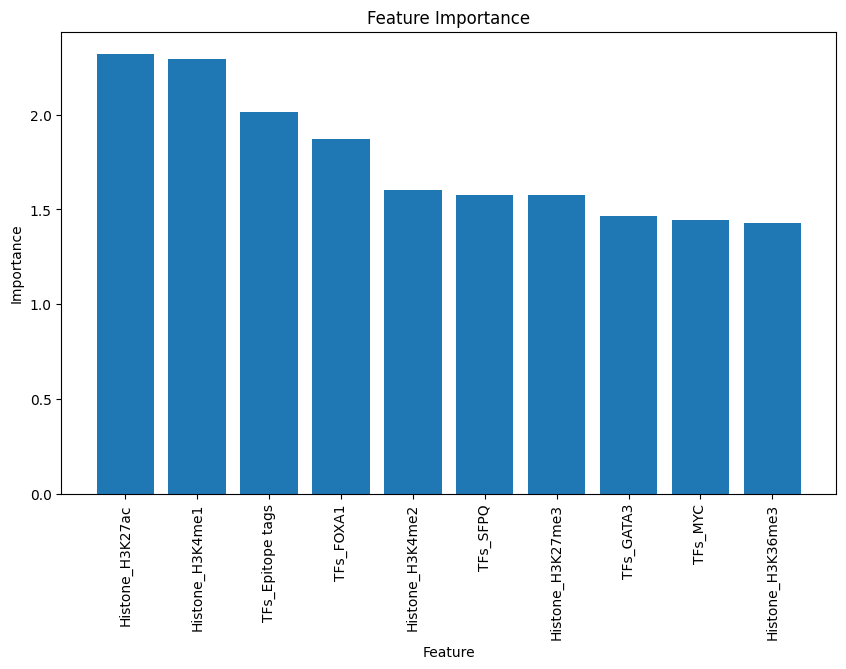

In [63]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
